1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [13]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

In [3]:
import pandas as pd
import numpy as np
import datetime as dt

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [4]:
file_name = "data/data_000637.txt"
read_data = pd.read_csv(file_name)
N = 20000
data = read_data.copy()
data = data[:N]
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29
19996,1,0,63,3869200366,2517,6
19997,1,0,32,3869200366,2519,5
19998,1,0,17,3869200366,2522,21


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [5]:
x = data.groupby('BX_COUNTER')['BX_COUNTER'].max().max()
print("The estimated number of Bx in a ORBIT is:", x)

The estimated number of Bx in a ORBIT is: 3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [6]:
data["ABS_TIME"] = (data['TDC_MEAS'] * 25/30) + (data['BX_COUNTER'] * 25) + (data['ORBIT_CNT'] * x * 25)
data["ABS_TIME"] -= data.loc[0,"ABS_TIME"]
data["TIME_SERIES"] = pd.to_datetime(data["ABS_TIME"])
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME,TIME_SERIES
0,1,0,123,3869200167,2374,26,0.000000e+00,1970-01-01 00:00:00.000000000
1,1,0,124,3869200167,2374,27,8.125000e-01,1970-01-01 00:00:00.000000000
2,1,0,63,3869200167,2553,28,4.476625e+03,1970-01-01 00:00:00.000004476
3,1,0,64,3869200167,2558,19,4.594125e+03,1970-01-01 00:00:00.000004594
4,1,0,64,3869200167,2760,25,9.649125e+03,1970-01-01 00:00:00.000009649
...,...,...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29,1.772940e+07,1970-01-01 00:00:00.017729402
19996,1,0,63,3869200366,2517,6,1.772948e+07,1970-01-01 00:00:00.017729483
19997,1,0,32,3869200366,2519,5,1.772953e+07,1970-01-01 00:00:00.017729532
19998,1,0,17,3869200366,2522,21,1.772962e+07,1970-01-01 00:00:00.017729620


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [7]:
all_data = read_data.copy()
all_data["ABS_TIME"] = (all_data['TDC_MEAS'] * 25/30) + (all_data['BX_COUNTER'] * 25) + (all_data['ORBIT_CNT'] * x * 25)
all_data["ABS_TIME"] -= all_data.loc[0,"ABS_TIME"]
all_data["TIME_SERIES"] = pd.to_datetime(all_data["ABS_TIME"])
duration = all_data.at[all_data.shape[0] - 1, 'TIME_SERIES'] - all_data.at[0, 'TIME_SERIES']
print("The duration of all data is:", duration)

duration = data.at[data.shape[0] - 1, 'TIME_SERIES'] - data.at[0, 'TIME_SERIES']
print("The duration for N =", N, "is:", duration)

The duration of all data is: 0 days 00:00:00.980140993
The duration for N = 20000 is: 0 days 00:00:00.017729603


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [8]:
noisy_ch = data.groupby('TDC_CHANNEL')['TDC_CHANNEL'].count().sort_values(ascending=False).head(3)
noisy_ch

TDC_CHANNEL
139    1693
64      996
63      969
Name: TDC_CHANNEL, dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [9]:
counting = data.groupby('ORBIT_CNT')['ORBIT_CNT'].count().sort_values()
print("The lowest orbit has value:", counting.head(1).values)
print("So, the number of non-empty orbits is the number of orbits itself:", counting.shape[0])

The lowest orbit has value: [33]
So, the number of non-empty orbits is the number of orbits itself: 200


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [10]:
uniq = data.groupby('TDC_CHANNEL')['ORBIT_CNT'].unique()
print("The number of unique orbits from TDC_CHANNEL=139 is:", len(uniq[139]))

The number of unique orbits from TDC_CHANNEL=139 is: 200


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [16]:
mask1 = data['FPGA'] == 0
mask2 = data['FPGA'] == 1
FPGA1 = data[mask1].groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()
FPGA2 = data[mask2].groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()
print(FPGA1)
print("\n")
print(FPGA2)

TDC_CHANNEL
1        13
2        23
3        17
4        22
5        29
       ... 
121      98
122      94
123     280
124     258
139    1171
Name: TDC_CHANNEL, Length: 118, dtype: int64


TDC_CHANNEL
1      435
2      479
3      362
4      393
5      246
      ... 
125      7
126      9
127     21
128     25
139    522
Name: TDC_CHANNEL, Length: 125, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

NameError: name 'plt' is not defined

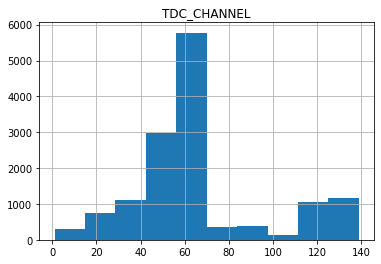

In [17]:
hist1 = data[mask1].hist(column = "TDC_CHANNEL")
plt.xlabel('TDC_CHANNEL')
plt.ylabel('count')
plt.title('FPGA 1')

hist2 = data[mask2].hist(column = "TDC_CHANNEL")
plt.xlabel('TDC_CHANNEL')
plt.ylabel('count')
plt.title('FPGA 2')
